# Post Transforms with spleen segmentation task
MONAI provides post-processing transforms for handling the model outputs. Currently, the transforms include:
- `Activations`: Adding activation layer (Sigmoid, Softmax, etc.).
- `AsDiscrete`: Converting to discrete values (Argmax, One-Hot, Threshold value, etc).
- `SplitChannel`: Splitting multi-channel data into multiple single channels.
- `KeepLargestConnectedComponent`: Extracting contour of segmentation result, which can be used to map to original image and evaluate the model.
- `LabelToContour`: Removing segmentation noise based on Connected Component Analysis.

MONAI supports multiple transform chains to apply different pre-transforms or post-transforms on the same data and concatenate the results, it provides `CopyItems` transform to make copies of specified items in the data dictionary and `ConcatItems` transform to combine specified items on the expected dimension, and also provides `DeleteItems` transform to delete unnecessary items to save memory.  
A typical usage is to scale and concatenate 3 different intensity ranges of an input image:
<p>
<img src="./images/multi_transform_chains.png" width="70%" alt='multi_transform_chains'>
</p>

This tutorial shows several of above post transforms based on the model output of spleen segmentation.

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import monai
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandAffined, Spacingd, Orientationd, ToTensord, \
    AsDiscrete, KeepLargestConnectedComponent, LabelToContour
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
from monai.utils import set_determinism
from monai.metrics import compute_meandice

## Set MSD Spleen dataset path
The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

In [2]:
data_root = '/workspace/data/medical/Task09_Spleen'
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [3]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [4]:
train_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96), pos=1,
                           neg=1, num_samples=4, image_key='image', image_threshold=0),
    ToTensord(keys=['image', 'label'])
])
val_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    ToTensord(keys=['image', 'label'])
])

## Define CacheDataset and DataLoader for training and validation

In [5]:
train_ds = monai.data.CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4
)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = monai.data.DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = monai.data.CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4
)
# val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = monai.data.DataLoader(val_ds, batch_size=1, num_workers=4)

32/32 Load and cache transformed data:  [==============================]
9/9 Load and cache transformed data:  [==============================]


## Create Model, Loss, Optimizer

In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)
loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

In [ ]:
epoch_num = 190
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    # validation progress
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                         to_onehot_y=True, mutually_exclusive=True)
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                  f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

## Execute post transforms on validation dataset
Here we test `AsDiscrete`, `KeepLargestConnectedComponent` and `LabelToContour`.

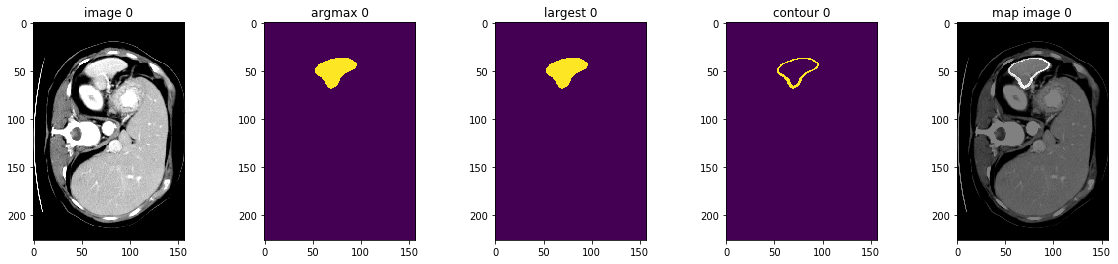

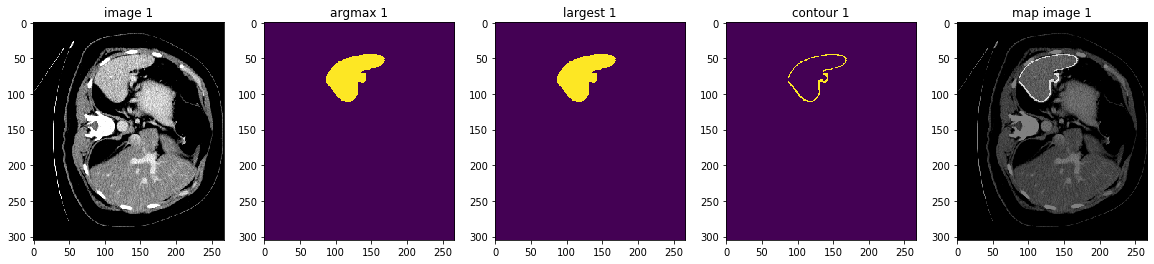

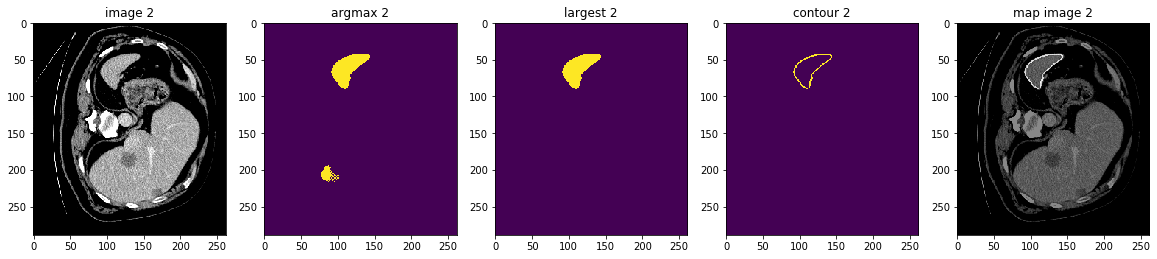

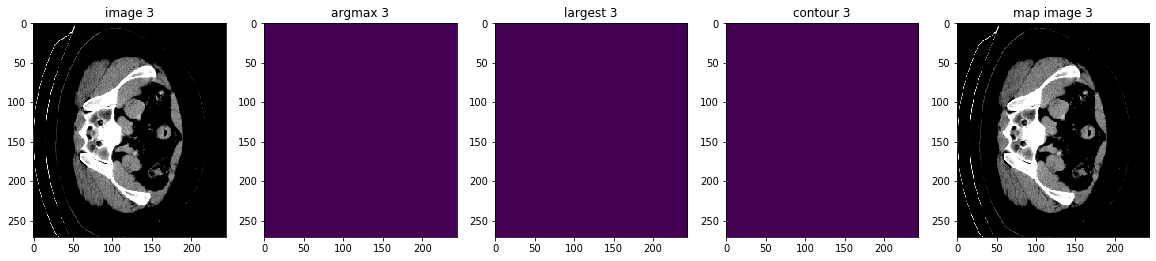

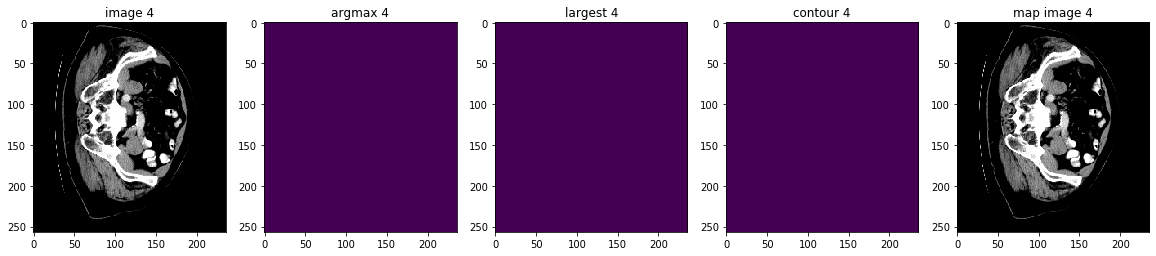

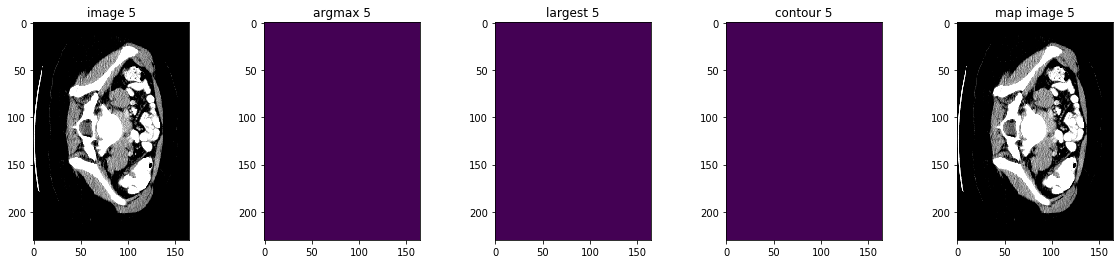

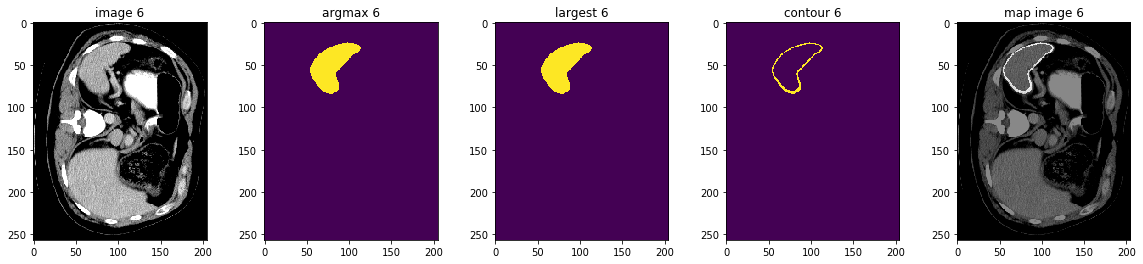

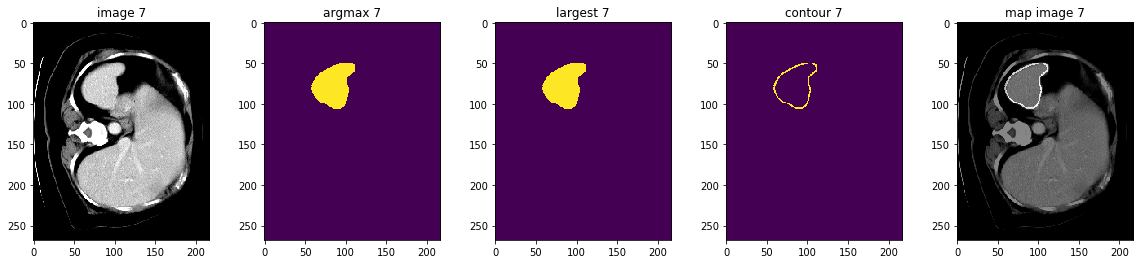

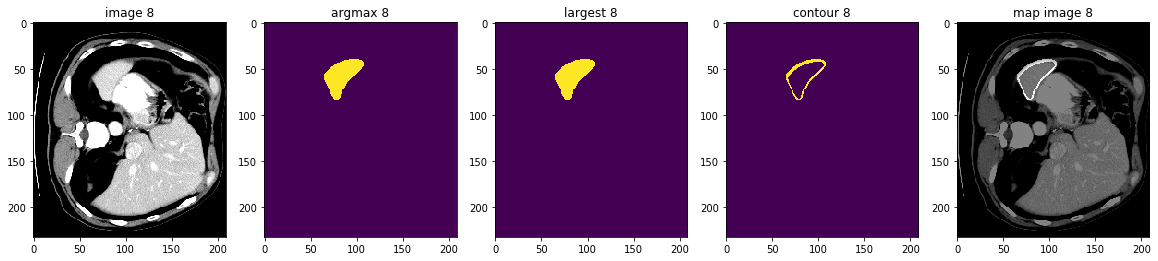

In [9]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data = val_data['image'].to(device)
        val_output = sliding_window_inference(val_data, roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure('check', (20, 4))
        plt.subplot(1, 5, 1)
        plt.title(f"image {str(i)}")
        plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap='gray')
        plt.subplot(1, 5, 2)
        plt.title(f"argmax {str(i)}")
        argmax = AsDiscrete(argmax=True)(val_output)
        plt.imshow(argmax.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 3)
        plt.title(f"largest {str(i)}")
        largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
        plt.imshow(largest.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 4)
        plt.title(f"contour {str(i)}")
        contour = LabelToContour()(largest)
        plt.imshow(contour.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 5)
        plt.title(f"map image {str(i)}")
        map_image = contour + val_data
        plt.imshow(map_image.detach().cpu()[0, 0, :, :, 80], cmap='gray')
        plt.show()